# Finding sentiment trends in tweets about a specific topic: A webscraping / NLP data science project

In this little practice project, I show how tweets about 'synthetic diamonds' have changed in sentiment over a course of 30 days in the summer of 2021. I also show how using different search terms, which objectively all describe 'synthetic diamonds', affected the resulting sentiment. The search terms used are:

1. 'synthetic diamonds'
2. 'artificial diamonds'
3. 'fake diamonds'
4. 'lab-grown diamonds'
5. 'man-made diamonds'
6. 'manufactured diamonds'


To run this code, you need access to the Twitter API. Once you have <a href="https://developer.twitter.com/en/docs/twitter-api/getting-started/getting-access-to-the-twitter-api">set up your developer account</a>, save your credentials in a file called Login.csv (located within the same folder as this notebook). The csv file should look like this:

```
description,key
consumerKey,######
consumerSecret,######
accessToken,######
accessTokenSecret,######
```

You will also need to set up a developer environment, which you can do on <a href="https://developer.twitter.com/en/account/environments"> this page</a>. The environment I'm using for this project is called 'diamonds30'.

## Data creation

### Importing packages

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

import tweepy
import re
import string
from textblob import TextBlob
import stopwordsiso
from wordcloud import WordCloud
from nltk.probability import FreqDist
import datetime
import pickle

### Loading the API and finding tweets

In [2]:
# load the Twitter API credentials
log = pd.read_csv('Login.csv')
consumerKey = log["key"][0]
consumerSecret = log["key"][1]
accessToken = log["key"][2]
accessTokenSecret = log["key"][3]

# create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

# get the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)

# create the API object while passing in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit=True)

# find all tweets containing the search term, for the past 30 days
search_term = 'synthetic+diamonds' #the '+' ensures that Twitter is searched for the exact phrase

tweets = api.search_30_day('diamonds30', query=search_term,
                           fromDate=202105250000, toDate=202106250000)

# create dataframe and add columns
df = pd.DataFrame([tweet for tweet in tweets], columns=['tweets'])


def get_text(tweet):
    if tweet.truncated is True:
        text = tweet.extended_tweet['full_text']
    else:
        text = tweet.text
    return text
    

def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9\_:]+', '', text)  # remove @mentions
    text = re.sub(r'RT[\s]+', '', text)  # remove retweet indicator plus whitespace
    text = re.sub(r'https?:\/\/\S+', '', text)  # remove hyperlinks
    text = text.replace('\n', ' ')  # remove superfluous linebreaks
    return text


df['text'] = df['tweets'].apply(get_text)
df['text_cleaned'] = df['text'].apply(clean_text)
df['screen_name'] = [i.user.screen_name for i in df['tweets']]
df['date'] = [i.created_at for i in df['tweets']]
df['week'] = [i.week for i in df['date']]
df['doy'] = [int(i.strftime('%j')) for i in df['date']]  # doy = day of year
df['polarity'] = [TextBlob(i).sentiment.polarity for i in df['text']]
# note: the polarity analysis treats emojis like their alt text

# make sure that tweets are in chronological order
df = df.sort_values(by=['date']).reset_index(drop=True)

In order to avoid having to repeat the Twitter search upon each startup of your environment (and thus using up your monthly search quota), consider saving the dataframe. The simplest way to do this, while retaining all data, is saving it as a pickle:

```
import pickle

with open(f'{search_term}.pkl', 'wb') as file:
    pickle.dump(df, file)
```

To reconstitute the dataframe, use:
```
with open(f'{search_term}.pkl', 'rb') as file:
    df = pickle.load(file)
```



## Data visualization

Next, we will visualize the content of the tweets for each search term, by plotting 
* a wordcloud
* a word-frequency plot
* a timeseries of tweet polarity

For the first two plots, the text needs to be reformated into one long string of words and cleaned further. One key element of text cleaning is removing stopwords, i.e. frequently occurring words that do not hold any of the text's meaning. Here we use the Python package <a href="https://github.com/stopwords-iso/stopwords-iso">stopwords-iso</a>, most comprehensive collection of stopwords I could find.

### Cleaning the data

In [3]:
df = df.dropna(axis=0)
tweetlist = [twts.lower() for twts in df['text_cleaned']]  # list of tweets
wordstring = ' '.join(tweetlist)  # string of tweets
wordlist = [wrd for wrd in wordstring.split(' ')]  # list of words
while '' in wordlist: wordlist.remove('')  # remove all empty list entries


wordlist2 = []  # list of words without stopwords, mentions, or links
stopwords = stopwordsiso.stopwords("en")

for word in wordlist:
    if word not in stopwords \
       and not ('@' in word) \
       and not ('http' in word) \
       and not ('&amp;' in word):
        wordlist2.append(word)


wordlist_clean = []  # list of words, stripped of punctuation
for word in wordlist2:
    word_stripped = word.strip(string.punctuation + '…')
    if word_stripped not in stopwords and len(word_stripped) > 2:
        wordlist_clean.append(word_stripped)
    
    
wordstring_clean = ' '.join(wordlist_clean)

### Generating Wordcloud

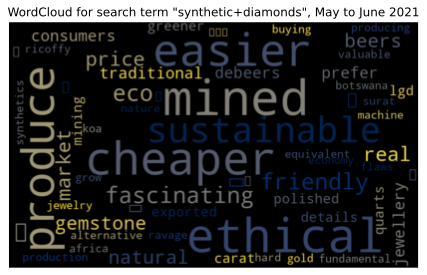

In [21]:
stopwords.update(['artificial', 'synthetic', 'diamond', 'diamonds', 'lab', 'grown'])
# expand stopwords to include words from the search term. those are, of course, the most frequently occurring words 
# in the text, so they clutter up the wordcloud and obscure what we want to see

wordCloud = WordCloud(width=1000, height=600, max_font_size=119,
                      stopwords=stopwords, max_words=60,
                      collocations=False, colormap='cividis')
wordCloud.generate(wordstring_clean)

plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.title(f'WordCloud for search term "{search_term}", May to June 2021')
plt.show()

### Generating word-frequency plot

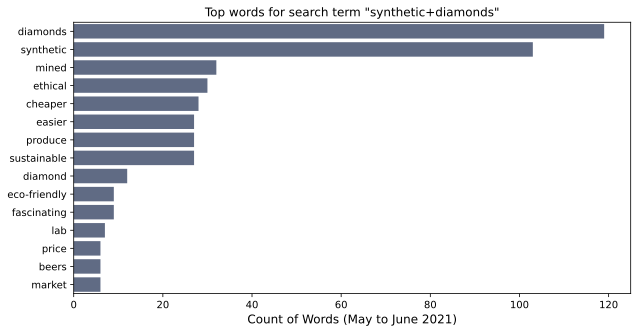

In [22]:
df_freq = pd.DataFrame(wordlist_clean)  # create dataframe from cleaned list of words
df_freq = df_freq[0].value_counts()  # count occurrence of each word

freqdoctor = FreqDist()  # convert df_freq to a sorted dictionary
for words in df_freq:
    freqdoctor[words] += 1

df_freq = df_freq[:15, ]  # only plot first 15 entries

plt.figure(figsize=(10, 5))
sns.barplot(x=df_freq.values, y=df_freq.index, alpha=0.8, color='#31436d')
plt.title(f'Top words for search term "{search_term}"')
plt.xlabel('Count of Words (May to June 2021)', fontsize=12)
plt.show()

### Timeseries plots: Generating framework variables

In [6]:
days = list(df['doy'].unique())
dates = []
for day in range(days[0], days[-1] + 1, 5):
    x = datetime.datetime(2021, 1, 1) + datetime.timedelta(int(day) - 1)
    date = x.strftime('%d.%m.')
    dates.append(date)
    
polarity_pos = dict.fromkeys(days, 0)  # initialize dicts counting pos/neg polarity for the days
polarity_neg = dict.fromkeys(days, 0)
count_pos = dict.fromkeys(days, 0)
count_neg = dict.fromkeys(days, 0)

for i in df.index:
    if df['polarity'][i] >= 0:
        polarity_pos[df['doy'][i]] += df['polarity'][i]
        count_pos[df['doy'][i]] += 1
    if df['polarity'][i] < 0:
        polarity_neg[df['doy'][i]] += df['polarity'][i]
        count_neg[df['doy'][i]] += 1
    
count_all = df['doy'].value_counts().to_dict()
count_n = list(count_neg.values())
count_p = list(count_pos.values())

### Timeseries plots: Tweet count (for one search term)

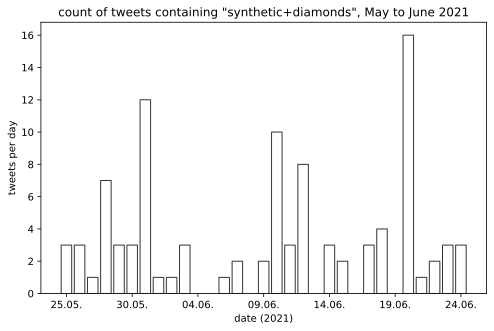

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.axhline(y=0, color='black', linewidth=0.2)
plt.bar(x=count_all.keys(), height=count_all.values(),
        edgecolor='black', color='none', alpha=0.8)
ax.set_xlabel('date (2021)')
ax.set_xticks(list(range(days[0], days[-1] + 1, 5)))
ax.set_xticklabels(dates)
ax.set_ylabel('tweets per day')
ax.set_title(f'count of tweets containing "{search_term}", May '
             'to June 2021')
plt.show()

### Timeseries plots: Count of positive/negative tweets (for one search term)

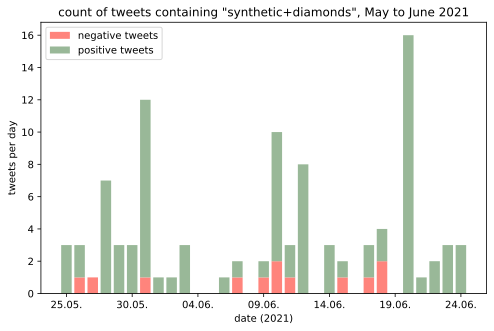

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.axhline(y=0, color='black', linewidth=0.2)
plt.bar(x=count_neg.keys(), height=count_n,
        color='#FF847C', label='negative tweets')
plt.bar(x=count_pos.keys(), height=count_p, bottom=count_n,
        color='#99B898', label='positive tweets')
ax.set_xlabel('date (2021)')
ax.set_xticks(list(range(days[0], days[-1] + 1, 5)))
ax.set_xticklabels(dates)
ax.set_ylabel('tweets per day')
ax.set_title(f'count of tweets containing "{search_term}", May to June 2021')
ax.legend(loc=0)
plt.show()

### Timeseries plots: Sum of polarity per day (for one search term)

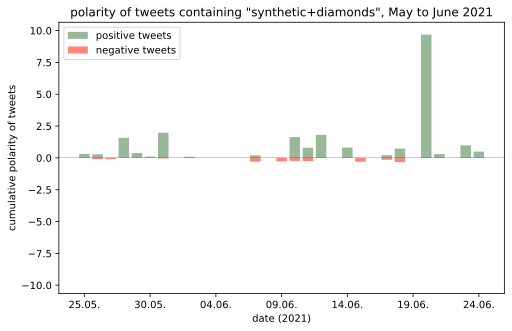

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.axhline(y=0, color='black', linewidth=0.2)
plt.bar(x=days, height=list(polarity_pos.values()),
        color='#99B898', label='positive tweets')
plt.bar(x=days, height=list(polarity_neg.values()),
        color='#FF847C', label='negative tweets')
ax.set_xlabel('date (2021)')
ax.set_xticks(list(range(days[0], days[-1] + 1, 5)))
ax.set_xticklabels(dates)
abs_max = max(max(polarity_pos.values()), abs(min(polarity_pos.values())))
ax.set_ylim([abs_max * -1.1, abs_max * 1.1])  # centers y-axis on zero
ax.set_ylabel('cumulative polarity of tweets')
ax.set_title(f'polarity of tweets containing "{search_term}", May to June 2021')
ax.legend(loc=0)
plt.show()

## Comparison of search terms

Let's see how using different search terms affects the results for polarity. For this, we load the pickles we previously created of the dataframes (one dataframe per query), and add a column 'query' to each dataframe. This will allow us to distinguish between search terms in the following plots.

### Creating dataframe with all results

In [11]:
# load all pickles into dataframes, add column 'query'
with open('synthetic+diamonds.pkl', 'rb') as file:
    df1 = pickle.load(file)
    df1['query'] = pd.Series(
        ['synthetic+diamonds' for x in range(len(df1.index))])
with open('artificial+diamonds.pkl', 'rb') as file:
    df2 = pickle.load(file)
    df2['query'] = pd.Series(
        ['artificial+diamonds' for x in range(len(df2.index))])
with open('fake+diamonds.pkl', 'rb') as file:
    df3 = pickle.load(file)
    df3['query'] = pd.Series(
        ['fake+diamonds' for x in range(len(df3.index))])
with open('lab-grown+diamonds.pkl', 'rb') as file:
    df4 = pickle.load(file)
    df4['query'] = pd.Series(
        ['lab-grown+diamonds' for x in range(len(df4.index))])
with open('man-made+diamonds.pkl', 'rb') as file:
    df5 = pickle.load(file)
    df5['query'] = pd.Series(
        ['man-made+diamonds' for x in range(len(df5.index))])
with open('manufactured+diamonds.pkl', 'rb') as file:
    df6 = pickle.load(file)
    df6['query'] = pd.Series(
        ['manufactured+diamonds' for x in range(len(df6.index))])
    
# concatenate all dataframes into one comprehensive dataframe
df_all = df1.append(df2, ignore_index=True)\
    .append(df3, ignore_index=True)\
    .append(df4, ignore_index=True)\
    .append(df5, ignore_index=True)\
    .append(df6, ignore_index=True)

# create new column 'is_pos' in df_all, indicating whether a tweet is positive, neutral, or negative
is_pos = []
for i in df_all.index:
    if df_all['polarity'][i] > 0:
        is_pos.append(1)
    elif df_all['polarity'][i] < 0:
        is_pos.append(-1)
    else:
        is_pos.append(0)
df_all['is_pos'] = is_pos

# create color palette to use for polarity in the following plots
BlGyGr = ['black', '#bbbbbb', 'limegreen']

First, we want to visualize which search term was popular at which time. We can do this, for example, with a KDE (kernel density estimate) plot. Here I show a kde line plot and a filled kde plot:

### Tweet count (for all search terms) in a KDE line plot

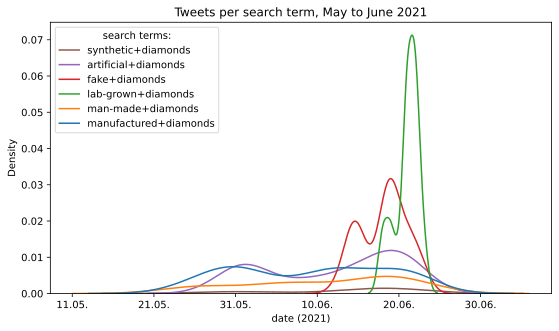

In [26]:
fig, ax = plt.subplots(figsize=(9, 5))
g = sns.kdeplot(data=df_all, x="doy", hue="query", legend=False)
g.set(xlabel='date (2021)',
      title='Tweets per search term, May to June 2021')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.'))  # formats the dates on the x-axis
plt.legend(labels=list(df_all['query'].unique()), 
           loc='upper left', title='search terms:')
plt.show()

### Tweet count (for all search terms) in a KDE filled plot

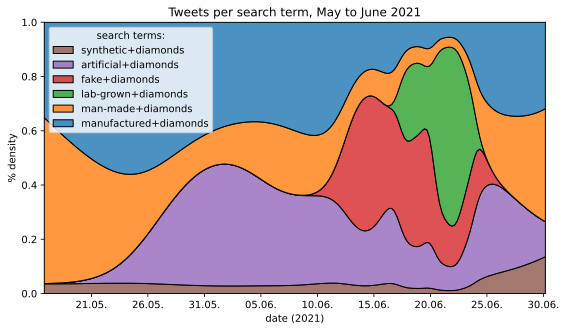

In [27]:
fig, ax = plt.subplots(figsize=(9, 5))
g = sns.kdeplot(data=df_all, x="doy", hue="query", multiple='fill', legend=False, alpha=0.8)
g.set(xlabel='date (2021)', ylabel='% density',
      title='Tweets per search term, May to June 2021')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.'))
plt.legend(labels=list(df_all['query'].unique()),
           loc='upper left', title='search terms:')
plt.show()

We can visualize trends in polarity for example in a kde line plot. Trends can be seen both in the cummulative plot for all search terms, as well as a facet grid plot:

### Polarity (for all search terms) in a KDE line plot

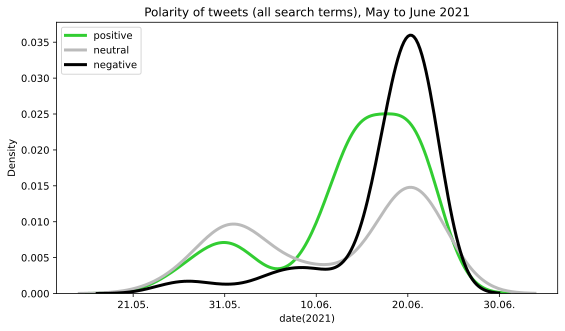

In [28]:
fig, ax = plt.subplots(figsize=(9, 5))
g = sns.kdeplot(data=df_all, x="doy", hue="is_pos", legend=False,
                palette=BlGyGr, linewidth=3)
g.set(xlabel='date(2021)', title='Polarity of tweets (all search terms), May '
      'to June 2021')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.'))
plt.legend(labels=['positive', 'neutral', 'negative'],
           loc='upper left')
plt.savefig('kdeplot_all_queries_polarity.png', dpi=200)
plt.show()

### Facet grid of polarity trends for each search term

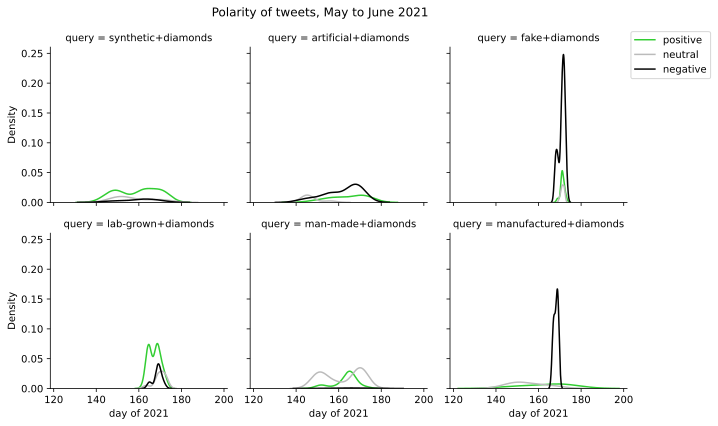

In [29]:
g = sns.FacetGrid(df_all, col="query", col_wrap=3)
g.map_dataframe(sns.kdeplot, x="doy", hue="is_pos", palette=BlGyGr)
g.set_axis_labels("day of 2021", "Density")
g.fig.subplots_adjust(top=0.9)  # create space between super-title and plot
g.fig.suptitle('Polarity of tweets, May to June 2021')
g.fig.tight_layout()
# needs external legend, located outside of figure axes:
plt.legend(labels=['positive', 'neutral', 'negative'],
           loc='upper right', bbox_to_anchor=(1.5, 2.33))
plt.show()

This concludes my short demonstration of sentiment-trend-analysis of tweets. 

This code is available on GitHub (https://github.com/BirkoRuzicka/twitter_sentiment) under CC0 license, so you are free to use it in any way without giving credit or asking for permission in any way. However, considering that I put a lot of time and effort into preparing this code and notebook, I would be very happy to hear/read about any projects it is used in (e.g. by <a href="https://twitter.com/lets_boldly_go">tagging me on Twitter</a>).